# Imports & Configuration

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

# Read the input data

In [7]:
path = "../../.data/метрики_торгового_эквайринга.csv"
data = pd.read_csv(path, parse_dates=[1], index_col=[0])

# заполним пропуски
cols = data.columns.drop("datetime")
data.loc[:, cols] = data.loc[:, cols].interpolate(method="linear", limit_area="inside", axis="rows")

print(data.shape)
display(data.head())

(1725120, 10)


,datetime,317694,317695,317696,317709,317710,317711,317768,370018,389614
0,2020-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN
1,2020-01-01 00:01:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN
2,2020-01-01 00:02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,2020-01-01 00:03:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN
4,2020-01-01 00:04:00,0.0,0.0,0.0,0.0,0.0,0.0,4.0,NaN,NaN


In [8]:
data["datetime"].agg(["min", "max"])

min   2020-01-01 00:00:00
max   2023-04-12 23:59:00
Name: datetime, dtype: datetime64[ns]

In [9]:
data.dtypes

datetime    datetime64[ns]
317694             float64
317695             float64
317696             float64
317709             float64
317710             float64
317711             float64
317768             float64
370018             float64
389614             float64
dtype: object

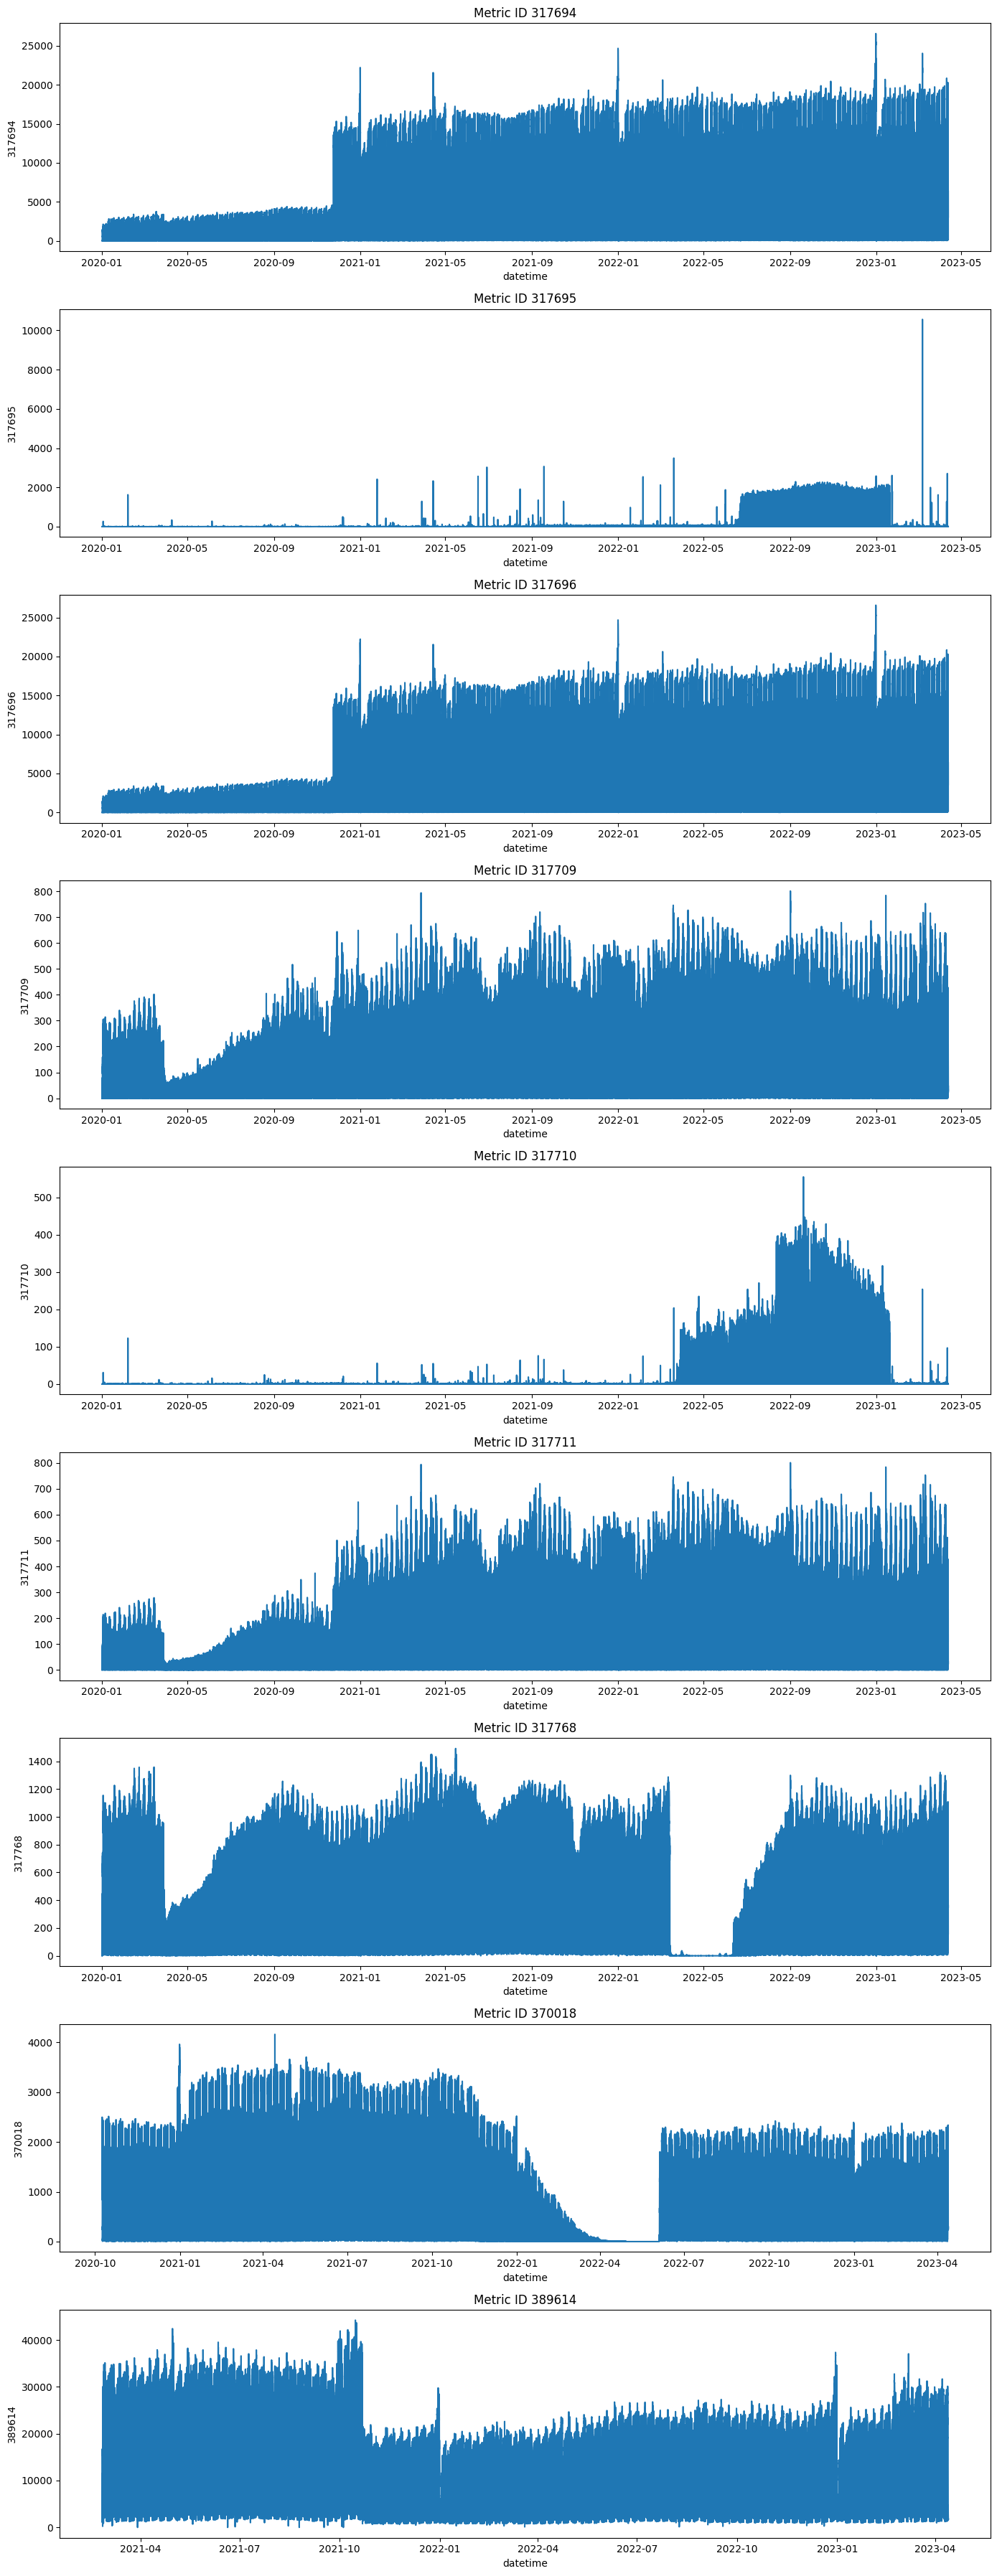

In [143]:
metrics = data.columns.drop("datetime")
fig, ax = plt.subplots(ncols=1, nrows=len(metrics), figsize=(14, 4*len(metrics)))
for i, metric in enumerate(metrics):
  sns.lineplot(data=data, x="datetime", y=metric, ax=ax[i])
  ax[i].set_title(label="Metric ID %s" % metric)
fig.tight_layout()
fig.show()

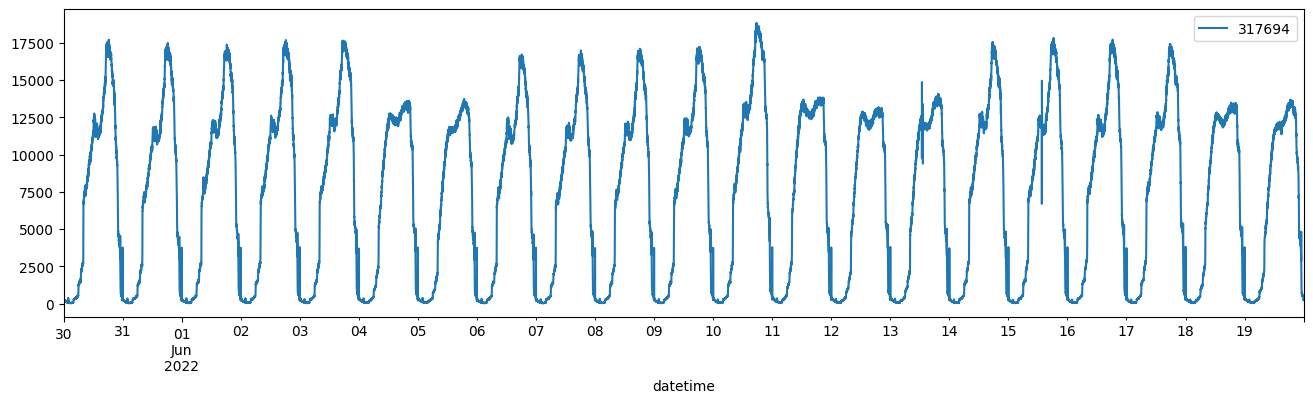

In [10]:
datetime_from, datetime_to = "2022-05-30 00:00:00", "2022-06-19 23:59:00"
data.loc[
    (data["datetime"] >= datetime_from) & (data["datetime"] <= datetime_to), ["datetime", "317694"]
    ].set_index("datetime").plot(figsize=(16, 4));

In [11]:
# готовим данные, на которых мы будем пробовать оценивать близость между днями
metric_id = "317694"
pred_day = data.loc[
    (data["datetime"] >= "2022-06-13 00:00:00") & (data["datetime"] <= "2022-06-13 23:59:00"), ["datetime", metric_id]
].rename(columns={metric_id: "value"})
train_data = data.loc[
    (data["datetime"] >= "2022-06-06 00:00:00") & (data["datetime"] <= "2022-06-12 23:59:00"), ["datetime", metric_id]
].rename(columns={metric_id: "value"})

print(pred_day.shape)
print(train_data.shape)

(1440, 2)
(10080, 2)


# Метод поиска похожих дней

## Корреляция Пирсона

In [145]:
groups = train_data.groupby(by=train_data["datetime"].dt.normalize(), as_index=False)
for day, curr_day in groups:
  cor = stats.pearsonr(x=pred_day["value"].values, y=curr_day["value"].values).statistic
  print("Day {}, correlation: {:4f}".format(day, cor))

Day 2022-06-06 00:00:00, correlation: 0.985892
Day 2022-06-07 00:00:00, correlation: 0.983328
Day 2022-06-08 00:00:00, correlation: 0.983778
Day 2022-06-09 00:00:00, correlation: 0.985250
Day 2022-06-10 00:00:00, correlation: 0.985305
Day 2022-06-11 00:00:00, correlation: 0.995517
Day 2022-06-12 00:00:00, correlation: 0.997478


## Критерий согласия Пирсона

В начале преобразуем временной ряд в набор бинов для каждого из дней

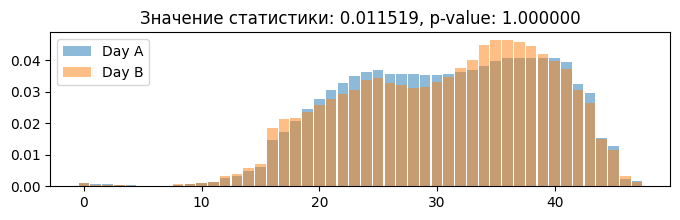

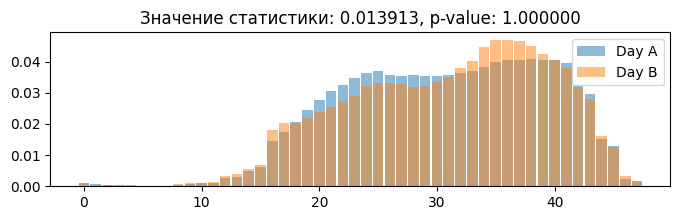

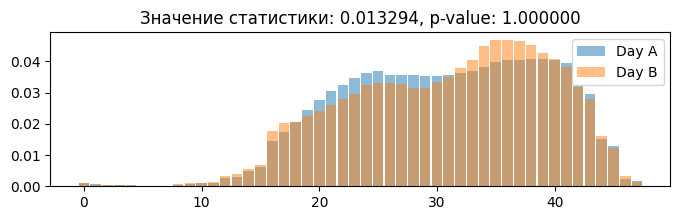

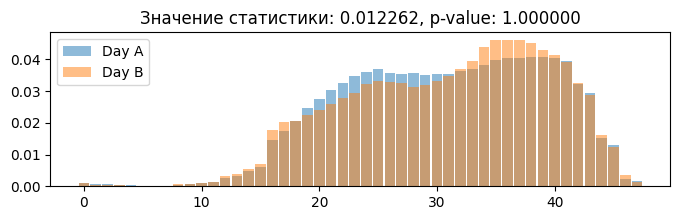

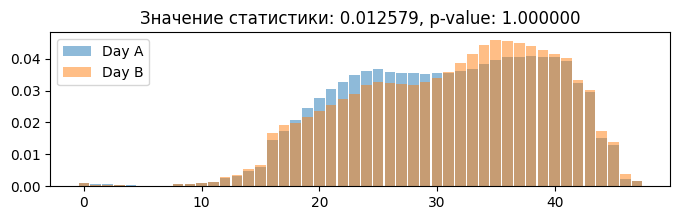

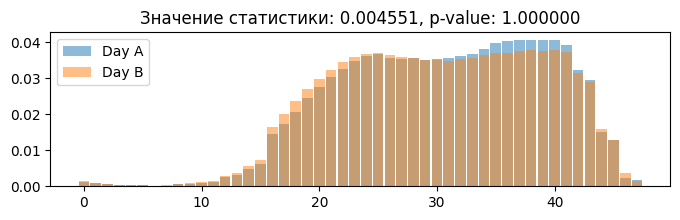

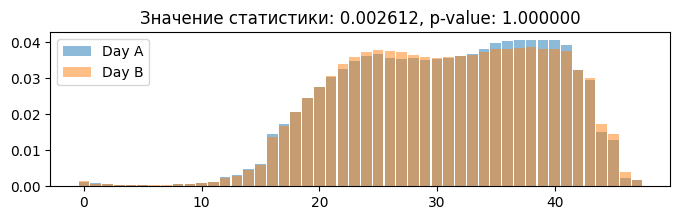

In [22]:
pred_bins = pred_day.groupby(pred_day["datetime"].dt.floor("30T"), as_index=False)["value"].median()
pred_bins /= pred_bins.sum()

groups = train_data.groupby(by=train_data["datetime"].dt.normalize(), as_index=False)
for day, curr_day in groups:
  day_bins = curr_day.groupby(curr_day["datetime"].dt.floor("30T"), as_index=False)["value"].mean()
  day_bins /= day_bins.sum()
  
  statistic, p_value = stats.chisquare(f_obs=pred_bins, f_exp=day_bins, ddof=0)
  s = "Значение статистики: {:.6f}, p-value: {:.6f}".format(statistic[0], p_value[0])

  fig, ax = plt.subplots(figsize=(8, 2))
  ax.bar(x=range(len(pred_bins)), height=pred_bins["value"], alpha=0.5, label="Day A", 
         align='center', width=0.9)
  ax.bar(x=range(len(day_bins)), height=day_bins["value"], alpha=0.5, label="Day B", 
         align='center', width=0.9)
  ax.set_title(s)
  ax.legend()
  fig.show();

## Dynamic Time Warping (DTW) distance

In [23]:
def dtw(p: list, q: list):
    # create empty cost matrix
    cost_m = [[0 for _ in range(len(q))] for _ in range(len(p))]

    # заполним матрицу
    cost_m[0][0] = abs(p[0] - q[0])
    for col in range(0, len(q)):

        if col != 0:
            cost_m[0][col] = abs(p[0] - q[col]) + cost_m[0][col - 1]

        for row in range(1, len(p)):
            if col == 0:
                cost_m[row][col] = abs(p[row] - q[col]) + cost_m[row - 1][col]
                continue

            cost_m[row][col] = \
                abs(p[row] - q[col]) + \
                min(cost_m[row - 1][col - 1], cost_m[row - 1][col], cost_m[row][col - 1])
            
    # wraping path identification
    row, col = len(p) - 1, len(q) - 1
    d = []
    d.append(cost_m[row][col])

    while row > 0 or col > 0:
        neighbors = [float("inf"), float("inf"), float("inf")]
        if row > 0 and col > 0:
            neighbors[2] = cost_m[row - 1][col - 1]
        if row > 0:
            neighbors[1] = cost_m[row - 1][col]
        if col > 0:
            neighbors[0] = cost_m[row][col - 1]
        idx = np.argmin(neighbors) + 1
        step = (idx // 2, idx % 2)
        row, col = row - step[0], col - step[1]
        d.append (cost_m[row][col])     

    return sum(d) / len(d), d, cost_m


In [24]:
groups = train_data.groupby(by=train_data["datetime"].dt.normalize(), as_index=False)
for day, curr_day in groups:
  d, path, cost_matrix = dtw(curr_day["value"].values, pred_day["value"].values)
  print("Day {}, distance: {:4f}".format(day, d))


Day 2022-06-06 00:00:00, distance: 136897.135362
Day 2022-06-07 00:00:00, distance: 133939.448785
Day 2022-06-08 00:00:00, distance: 147275.187088
Day 2022-06-09 00:00:00, distance: 154303.775574
Day 2022-06-10 00:00:00, distance: 281748.181132
Day 2022-06-11 00:00:00, distance: 62677.157391
Day 2022-06-12 00:00:00, distance: 55235.753964


# Обернем в класс

In [54]:
class SymCalc:
    def __init__(self, method: str = "dtw", bin_size: str = "30T", agg_f: str = "median",
                 roles: dict = {"datetime": "datetime", "value": "value"}) -> None:
        self.method = method
        self.bin_size = bin_size
        self.agg_f = agg_f
        self.roles = roles
        
    def __call__(self, p: pd.DataFrame, q: pd.DataFrame) -> float:
        if self.method == "dtw":
            d, _, _ = \
                self.dtw(p[self.roles.get("value")].values, q[self.roles.get("value")].values)
            return d
        
        if self.method == "chi_square":
            return self.chi_square(p, q)

    def chi_square(self, p: pd.DataFrame, q: pd.DataFrame) -> float:
        bins_p = p.groupby(by=p[self.roles.get("datetime")].dt.floor(self.bin_size), 
                           as_index=False)[self.roles.get("value")].apply(self.agg_f)
        bins_p /= bins_p.sum()
  
        bins_q = q.groupby(by=p[self.roles.get("datetime")].dt.floor(self.bin_size), 
                           as_index=False)[self.roles.get("value")].apply(self.agg_f)
        bins_q /= bins_q.sum()
        
        statistic, _ = stats.chisquare(f_obs=bins_p, f_exp=bins_q, ddof=0)
        return statistic[0]

    @staticmethod
    def dtw(p: list, q: list) -> float:
        # create empty cost matrix
        cost_m = [[0 for _ in range(len(q))] for _ in range(len(p))]

        # заполним матрицу
        cost_m[0][0] = abs(p[0] - q[0])
        for col in range(0, len(q)):

            if col != 0:
                cost_m[0][col] = abs(p[0] - q[col]) + cost_m[0][col - 1]

            for row in range(1, len(p)):
                if col == 0:
                    cost_m[row][col] = abs(p[row] - q[col]) + cost_m[row - 1][col]
                    continue

                cost_m[row][col] = \
                    abs(p[row] - q[col]) + \
                    min(cost_m[row - 1][col - 1], cost_m[row - 1][col], cost_m[row][col - 1])
                
        # wraping path identification
        row, col = len(p) - 1, len(q) - 1
        d = []
        d.append(cost_m[row][col])

        while row > 0 or col > 0:
            neighbors = [float("inf"), float("inf"), float("inf")]
            if row > 0 and col > 0:
                neighbors[2] = cost_m[row - 1][col - 1]
            if row > 0:
                neighbors[1] = cost_m[row - 1][col]
            if col > 0:
                neighbors[0] = cost_m[row][col - 1]
            idx = np.argmin(neighbors) + 1
            step = (idx // 2, idx % 2)
            row, col = row - step[0], col - step[1]
            d.append (cost_m[row][col])     

        return sum(d) / len(d), d, cost_m


In [59]:
# готовим данные, на которых мы будем пробовать оценивать близость между днями
metric_id = "317694"
p_day = data.loc[
    (data["datetime"] >= "2022-06-13 00:00:00") & (data["datetime"] <= "2022-06-13 23:59:00"), ["datetime", metric_id]
].rename(columns={metric_id: "value"}).reset_index(drop=True)
q_day = data.loc[
    (data["datetime"] >= "2022-06-12 00:00:00") & (data["datetime"] <= "2022-06-12 23:59:00"), ["datetime", metric_id]
].rename(columns={metric_id: "value"}).reset_index(drop=True)

print(p_day.shape)
print(q_day.shape)

(1440, 2)
(1440, 2)


In [60]:
sc = SymCalc(method="chi_square")
sc(p_day, q_day)

0.0016713520235279004